In [1]:
import numpy as np
import os
import argparse
from tqdm import tqdm
from matplotlib import pyplot as plt

import sys
from pathlib import Path
from scipy.signal import butter, lfilter

import json
import commentjson
import pickle
import scipy.io as sio
from pathlib import Path
import numpy as np


In [2]:
##IO.py


def read_commentjson(path):
    with open(path, mode="r") as f:
        return commentjson.load(f)


def load_json(path):
    """The function of loading json file

    Arguments:
        path {str} -- The path of the json file

    Returns:
        list, dict -- The obj stored in the json file
    """
    with open(path, 'r') as f:
        data = json.load(f)
    return data


def dump_json(path, data):
    """Dump data to json file

    Arguments:
        data {[Any]} -- data
        path {str} -- json file path
    """
    Path(path).parent.mkdir(parents=True, exist_ok=True)
    with open(path, 'w') as f:
        json.dump(data, f)


def load_text(path):
    with open(path) as f:
        return [l.replace("\n", "") for l in f.readlines()]


def write_pkl(data, file_name):
    with open(file_name, 'wb') as handle:
        pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)


def parse_txt(text_lines):
    time, ch1, ch2 = [], [], []
    for i, line in enumerate(text_lines):
        if i < 6:
            continue
        line = line.split("; ")
        try:
            time.append(float(line[0]))
            ch1.append(float(line[1]))
            ch2.append(float(line[2]))
        except:
            print("End line at {} ".format(i))
            break
    return np.asarray(time), np.asarray(ch1), np.asarray(ch2)


In [3]:
def conv1d(src, pattern):
    p_n, s_n = pattern.shape[0], src.shape[0]
    x = np.zeros_like(src)
    windowed_pattern = pattern
    print('Process conv1D with a known pattern ...')
    for i in range(s_n):
        windowed_src = src[i:p_n + i]
        if np.size(windowed_src) != np.size(windowed_pattern):
            windowed_pattern = windowed_pattern[:np.size(windowed_src)]
            x[i:p_n + i] += windowed_src * windowed_pattern
            break
        else:
            x[i:p_n + i] += windowed_src * windowed_pattern
    return x


def lowpass(x):

    def butter_lowpass_filter(data, cutoff, fs, order=5):
        b, a = butter(order, cutoff, fs=fs, btype='low', analog=False)
        y = lfilter(b, a, data)
        return y

    # create a butter worth filter
    order = 5
    fs = 1250.0
    cutoff = 30
    y = butter_lowpass_filter(x, cutoff, fs, order)
    y -= np.mean(y, axis=-1)
    return y


def min_max_norm(x):
    return (x - x.min(keepdims=True, axis=-1)) / (
        x.max(keepdims=True, axis=-1) - x.min(keepdims=True, axis=-1))


def parse_config():
    parser = argparse.ArgumentParser()
    parser.add_argument('--config', type=str)
    parser.add_argument('--low_pass', default=True, type=bool)
    parser.add_argument('--is_draw', default=True, type=bool)

    return parser.parse_args()

# Main Function

In [4]:
def run_similarity(time, src, patterns, root_dir, window=True):
    # if is_conv:
    #     src = conv1d(src, patterns)

    s_n = src.shape[0]
    src = src.reshape([-1, s_n])
    stride = 1
    sim_thres, interval_per = 10., 0.5
    kernel_size = patterns.shape[1]

    normed_src = min_max_norm(src)
    filted_src = lowpass(normed_src)

    steps = (s_n - kernel_size + 1) / stride
    steps += 1  # remainder
    tmp, poss_intervals = [], []
    windowed_pattern = min_max_norm(patterns)

    eps = 1e-9
    for i in tqdm(range(int(steps))):
        windowed_src = filted_src[:, i:kernel_size + i]
        # last step
        if i == steps - 1:
            windowed_pattern = windowed_pattern[:, :np.size(windowed_src)]
        windowed_src = min_max_norm(windowed_src)
        curr_dist = np.sqrt(
            np.sum(np.square(windowed_pattern - windowed_src), axis=-1) + eps)
        tmp.append(curr_dist)
        if i != 0 and len(tmp) % kernel_size == 0:
            tmp = np.asarray(tmp).T
            # hard threshold
            mask = tmp < sim_thres
            valid_sim = np.float32(mask)
            guessed_interval = np.sum(valid_sim, axis=-1) / kernel_size
            votes = np.sum((guessed_interval > 0.5).astype(np.float32) /
                           np.size(guessed_interval))
            if votes > interval_per:
                poss_intervals.append(i)
            tmp = []
    convert2time = time[poss_intervals]
    print('Finish evaluating')
    print('Totoal find %i' % len(poss_intervals))
    print('Window size %i' % kernel_size)
    np.save(os.path.join(root_dir, "index.npy"), poss_intervals)
    
    return convert2time, filted_src


# Data generation

In [7]:
#generate data
data_path = "../signal_det/data/meas_scope_20210823.txt"
time, raw_data, triangle_waves = parse_txt(load_text(data_path))
root_dir = os.path.split(data_path)[0]

End line at 2537861 


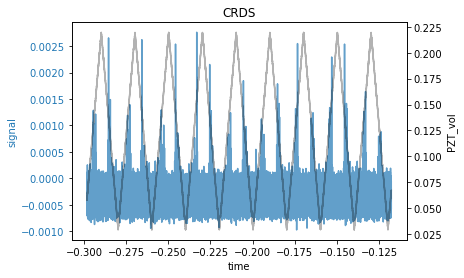

In [8]:
fig, ax1 = plt.subplots()
plt.title('CRDS')
plt.xlabel('time')
ax2 = ax1.twinx()

ax1.set_ylabel('signal', color='tab:blue')
ax1.plot(time,raw_data, color='tab:blue', alpha=0.7)
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2.set_ylabel('PZT_vol', color='black')
ax2.plot( time, triangle_waves, color='black', alpha=0.3)
ax2.tick_params(axis='y', labelcolor='black')


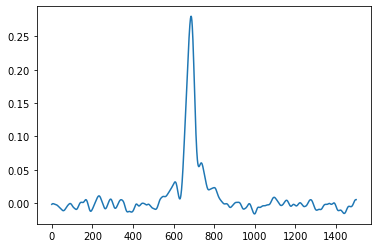

In [26]:
pattern_path = "../signal_det/asset/pattern.npy"
pattern0 = np.load(pattern_path)

plt.plot(range(len(pattern0)) , pattern0)

# Running

In [9]:
pattern_path = "../signal_det/asset/pattern.npy"
if os.path.isfile(pattern_path):
        patterns = np.stack([np.load(pattern_path)])
else:
    patterns = np.stack([
        np.load(os.path.join(pattern_path, p))
        for p in os.listdir(pattern_path)
    ])

convert2time, filted_src = run_similarity(time, raw_data, patterns, root_dir, False)

100%|██████████| 2536357/2536357 [01:07<00:00, 37632.54it/s]

Finish evaluating
Totoal find 140
Window size 1500


# Find the cycle period idnex

In [10]:
def cyc_searching (data,window):
    temp_max =0 ;
    i=0
    ind_min= 0;
    ind_max=0;
    A = data[0:window];
    B = data[window+1:2*window+1];
    if((np.max(B)-np.max(A))>0):
        direct ="up";
    else:
        direct = "down"
    collect = []
    while(1):
        A = data[i:i+window];
        B = data[i+window+1:i+2*window+1];
        if ((np.max(B)-np.max(A)) == 0): i=i+window;
        if(direct == "up"):
            #start collect
            if((np.max(B)-np.max(A))>0):       
                i=i+window;
                if((i+2*window+1)>len(data)): return collect;
            else:            
                ind_max=i+np.argmax(A)
                direct = "down";
                
        if(direct == "down"):        
            if((np.min(A)- np.min(B))>0):
                i=i+window;
                if((i+2*window+1)>len(data)): return  collect;
            else:
                ind_min=i+np.argmin(A)
                collect.append([ind_max,ind_min])
                direct = "up"

In [11]:
window = 4000
ind = cyc_searching(triangle_waves,window)

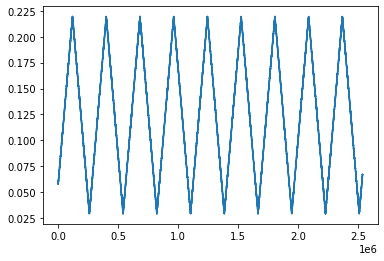

In [12]:
plt.plot(range(len(triangle_waves)) , triangle_waves)

In [13]:
ind

[[119496, 260101],
 [400687, 541377],
 [681949, 822650],
 [963225, 1103915],
 [1244472, 1385157],
 [1525730, 1666394],
 [1807048, 1947530],
 [2088290, 2228894],
 [2369490, 2510139]]

# Convert result from time base to index base

In [14]:
convert2index=[]
for t in convert2time:
    ind_peak = np.where(time ==t)[0][0]
    convert2index.append(ind_peak)



In [15]:
convert2index[10]

194999

# rearrange the result

In [23]:
new_time = []
new_filted_src = []
new_triangle_waves = []
new_peak_collect = []
for i in range(len(ind)):
    tmp=[]
    new_time.append(time[ind[i][0] :ind[i][1]])
    new_filted_src.append(raw_data[ind[i][0] :ind[i][1]])
    new_triangle_waves .append(triangle_waves [ind[i][0] :ind[i][1]])
    
    for x in convert2index:
        if((x < ind[i][1]) & (x > ind[i][0] )):
            tmp.append(x)
    new_peak_collect.append(tmp)
    

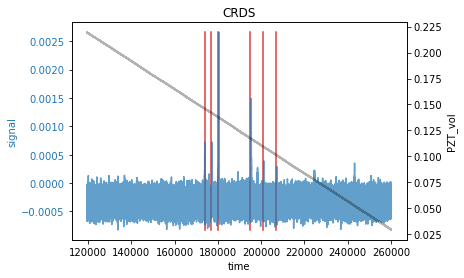

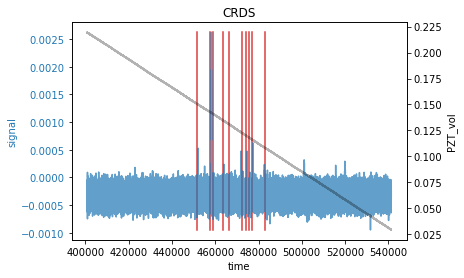

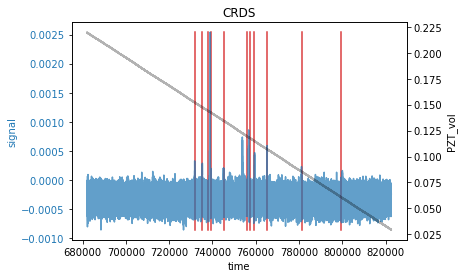

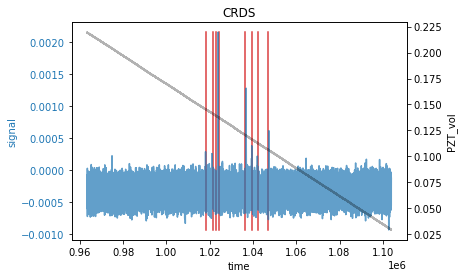

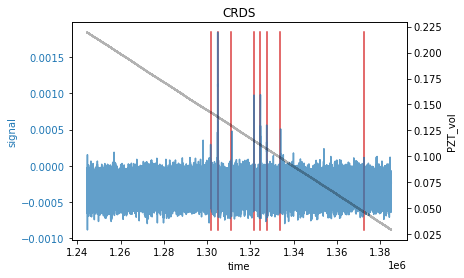

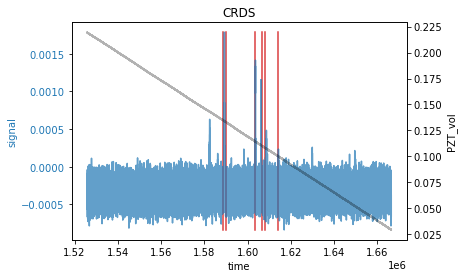

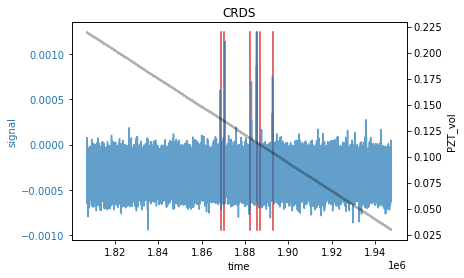

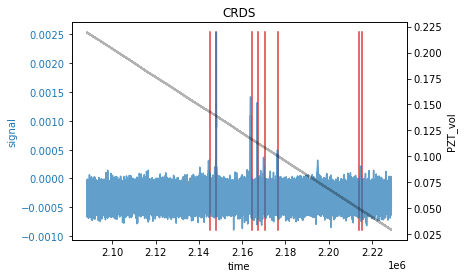

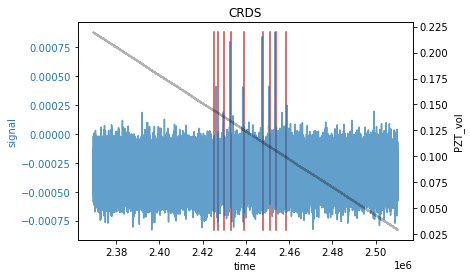

In [24]:
for num in range(len(ind)):
    min_max = [np.min(new_filted_src[num]), np.max(new_filted_src[num])]
    x= np.arange(ind[num][0],ind[num][1],1)
    fig, ax1 = plt.subplots()
    plt.title('CRDS')
    plt.xlabel('time')
    ax2 = ax1.twinx()
    ax1.set_ylabel('signal', color='tab:blue')

    for i in new_peak_collect[num]:
        ax1.plot([i,i],min_max, color='tab:red', alpha=0.9)  

    ax1.plot(x,new_filted_src[num], color='tab:blue', alpha=0.7)
    ax1.tick_params(axis='y', labelcolor='tab:blue')

    ax2.set_ylabel('PZT_vol', color='black')
    ax2.plot(x, new_triangle_waves[num], color='black', alpha=0.3)
    ax2.tick_params(axis='y', labelcolor='black')

# Statistic

In [18]:
delta = []
for i in range(len(new_peak_collect)):
    for j in range(len(new_peak_collect[i])):
        if(j!=0):
            d = new_peak_collect[i][j] - pre_tmp
            delta.append(d)
        pre_tmp = new_peak_collect[i][j]
    

max= 3000


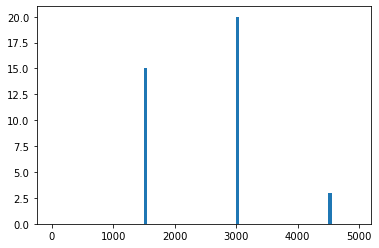

In [19]:
bins = range(0, 5000, 50)
counts, bins = np.histogram(delta,bins)
max_val = bins[np.argmax(counts)]
plt.stairs(counts, bins,fill=True)
print("max=",max_val)

#3000 = harmonic

# Sample-1

In [20]:
num =0
go_start =170000
go_end = 210000
min_max = [np.min(new_filted_src[num]), np.max(new_filted_src[num])]
x= np.arange(ind[num][0],ind[num][1],1)
i_start = np.where(x==go_start)[0][0]
i_end = np.where(x==go_end)[0][0]

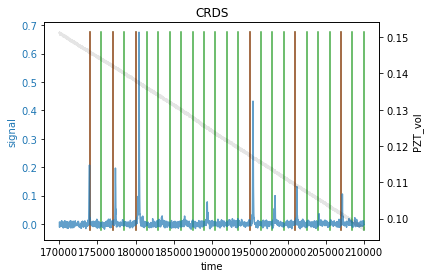

In [21]:


fig, ax1 = plt.subplots()
plt.title('CRDS')
plt.xlabel('time')
ax2 = ax1.twinx()
ax1.set_ylabel('signal', color='tab:blue')

for i in range(25):
    i_set=i*1500+new_peak_collect[num][0]
    ax1.plot([i_set,i_set],min_max, color='tab:green', alpha=0.9)  
for i in new_peak_collect[num]:
    ax1.plot([i,i],min_max, color='tab:red', alpha=0.7)  
    
ax1.plot(x[i_start:i_end],new_filted_src[num][i_start:i_end], color='tab:blue', alpha=0.7)
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2.set_ylabel('PZT_vol', color='black')
ax2.plot(x[i_start:i_end], new_triangle_waves[num][i_start:i_end], color='black', alpha=0.1)
ax2.tick_params(axis='y', labelcolor='black')


# Sample-2

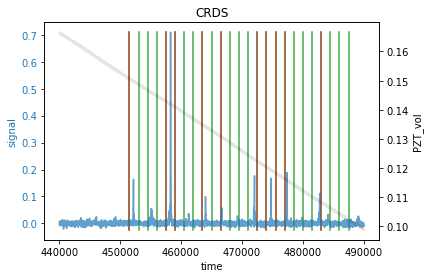

In [22]:
num =1
go_start =440000
go_end = 490000
min_max = [np.min(new_filted_src[num]), np.max(new_filted_src[num])]
x= np.arange(ind[num][0],ind[num][1],1)
i_start = np.where(x==go_start)[0][0]
i_end = np.where(x==go_end)[0][0]

fig, ax1 = plt.subplots()
plt.title('CRDS')
plt.xlabel('time')
ax2 = ax1.twinx()
ax1.set_ylabel('signal', color='tab:blue')

for i in range(25):
    i_set=i*1500+new_peak_collect[num][0]
    ax1.plot([i_set,i_set],min_max, color='tab:green', alpha=0.9)  
for i in new_peak_collect[num]:
    ax1.plot([i,i],min_max, color='tab:red', alpha=0.7)  
    
ax1.plot(x[i_start:i_end],new_filted_src[num][i_start:i_end], color='tab:blue', alpha=0.7)
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2.set_ylabel('PZT_vol', color='black')
ax2.plot(x[i_start:i_end], new_triangle_waves[num][i_start:i_end], color='black', alpha=0.1)
ax2.tick_params(axis='y', labelcolor='black')